In [1]:
import numpy as np
import matplotlib

# Embed fonts into PDF/PS files
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors

import scipy.integrate

# Progress bars
import tqdm.notebook

In [2]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial']})

# Define parameters

In [11]:
## Physiological parameters

# mvn head sensitvity in the light: 0.38 sp/s / deg/s -- Beraneck & Cullen 2007
# => v_0 ~= 2.7
# => w_pc_mvn ~= 1.77 (Beraneck & Cullen report spont. ~60 sp/s)

# initial gain ~- 0.4 in mice (Katoh et al. 2015, Boyden & Raymond 2003)
# gain = k_eye * (v*k_MF - w_pc_mvn*w*k_PF)
# => k_eye = 1.06

# average learning in one day ~20-40% (Kimpo et al. 2014, Boyden & Raymond 2003)
# delta w ~= delta g/g_0 * v_0*k_MF / w_pc_mvn*k_PF
# delta w ~= 0.15 => delta g/g_0 ~= 0.3 on day 1
# w_infinity ~= k_LTD * k_PF * peak velocity / 2 (if delta CF = sin(wt))
# => k_LTD = 0.07 => delta w ~= 0.15

# memory retention ~75% after 24 hr calculated from Boyden & Raymond 2003

params = {
    'mf_0': 55, # Lasker et al. 2008
    'pf_0': 14, # Arenz et al. 2008 -- assume each MF EPSC evokes a GC spike
    'cf_0': 1,
    'mf_sensitivity': 0.14, # Lasker et al. 2008
    'pf_sensitivity': 0.42, # Arenz et al. 2008 (see simulations_heterosynaptic.ipynb for data)
    'w_i': 1,
    'pc_0':50, # Katoh et al. 2015
    'mvn_0': 12, # Nelson et al. 2003   
    'w_pc_mvn': 1.77,
    'k_eye': 1.06,
    'k_v': 2.4e-4, # to get 75% retention
    'tau_s': 1.,
    'tau_f': 0.017, # fast average
    'tau_mvn':1, # tau_f,v: average of activity being integrated at MVN
    'tau_learn': 0.15, # Boyden & Raymond 2003
    'tau_post': 3, # consistent with 4 hour window, Attwell et al. 2002
    'k_LTD': 0.07,
}
params['k_LTP'] = params['w_i']/params['pf_0'] + params['k_LTD']*params['cf_0']

## Behavioral parameters

# Kimpo et al. 2014, Nguyen-Vu et al. 2013, Boyden & Raymond 2003
stim_freq = 1 
peak_velocity_learn = 10 # deg/s

# We use a higher peak velocity during the post-training period
# so that the blow-up can be seen for the Hebbian rule
# (see Supplementary materials S.1)
peak_velocity_post = 30


# Define function for head velocity
head_learn = lambda t: peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t)
head_post_input = lambda t: peak_velocity_post*np.sin(2*np.pi*stim_freq*3600*t) # w/post-training input
head_post_no_input = lambda t: 0 # w/o post-training input

# Define function for retinal slip
rs_learn = lambda t: np.sin(2*np.pi*stim_freq*3600*t)
rs_post = lambda t: 0

# ODE solver code

We use built-in ODE solvers (implemented by `scipy.integrate`) to perform simulations. The ODE solvers take functions that have the current time value (`t`) and the state (`y`) at that time as arguments and return a vector of the same size as `y` that gives the instantaneous derivative. We also provide a function for the Jacobian, which takes the same arguments and returns the Jacobian matrix.

We solve a system of 6 variables, with `y[0]` defining $w$, `y[1]` $v$, `y[2]` the exponential average $\langle\text{MF}(\text{MVN} - \theta)\rangle_{\tau_{f,v}}$, `y[3]` $\theta = \langle\text{MVN}\rangle_{\tau_s}$, `y[4]` $\langle\text{PF}\rangle_{\tau_f}$, and `y[4]` $\langle\text{PF}\cdot\text{CF}\rangle_{\tau_f}$.

In [9]:
# Function to pass to ODE solver
def hebbian(t, y, head, retinal_slip, learn, params, decay_rate=0):
    '''
    head: a function taking a time argument that returns the head velocity
    retinal_slip: a function taking a time argument that returns the retinal slip velocity
    learn: set to True if in the training period, False if in the post-training period
    params: list containing the physiological parameters
    decay_rate: defines a decay of the weight v (see Supplementary materials, S.1)
    '''
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['pf_sensitivity']*head(t)
    delta_cf = retinal_slip(t)
    
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    cf = params['cf_0'] + delta_cf
    
    w = y[0]
    v = y[1]
    
    delta_pc = (w - params['w_i'])*mf
    pc = delta_pc + params['pc_0']
    mvn = v*mf - params['w_pc_mvn']*pc + params['mvn_0']
    
    dydt = np.zeros(6)
    dydt[0] = 1/tau_w * (-y[0] + params['k_LTP']*y[4] - params['k_LTD']*y[5])
    dydt[1] = params['k_v']*(-decay_rate*y[1] + y[2])
    dydt[2] = 1/params['tau_mvn'] * (-y[2] + mf*(mvn - y[3]))
    dydt[3] = 1/params['tau_s'] * (-y[3]+ mvn)
    dydt[4] = 1/params['tau_f'] * (-y[4] + pf)
    dydt[5] = 1/params['tau_f'] * (-y[5] + pf*cf)
    return dydt

# Jacobian
def hebbianJac(t, y, head, retinal_slip, learn, params, decay_rate=0):
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['pf_sensitivity']*head(t)
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    
    jac = -1/params['tau_f']*np.eye(6)
    jac[0,:] = 1/tau_w*np.array([-1, 0, 0, 0, params['k_LTP'], -params['k_LTD']])
    jac[1,:] = params['k_v']*np.array([0, -decay_rate, 1, 0, 0, 0])
    jac[2,:] = 1/params['tau_mvn']*np.array([-params['w_pc_mvn']*pf*mf, mf**2,-1, -mf, 0,0])
    jac[3,:] = 1/params['tau_s']*np.array([-params['w_pc_mvn']*pf,mf,0,-1,0,0])

    return jac

# Simulation for Figure 1d

In [7]:
## Time steps for plotting (ODE solver uses variable time steps)

dt_learn = 1/3600 # h (= 1 s)
dt_post = 60/3600 # h (= 1 min)

In [12]:
T_learn = 0.5 # h

T_post = 24 - T_learn # s

t_learn = np.linspace(0, T_learn, int(T_learn/dt_learn))
t_post = np.linspace(0, T_post, int(T_post/dt_post))

# Initial condition
# v(t=0) was calculated based on parameters above
v_0 = 2.7
# Initial value for theta:
mvn_0 = v_0*params['mf_0'] - params['w_pc_mvn']*params['pc_0']
y_0 = np.array([params['w_i'], v_0, 0,mvn_0, params['pf_0'], params['pf_0']*params['cf_0']])

# Solution during the training period
sol_learn = scipy.integrate.solve_ivp(lambda t,y: hebbian(t,y, head_learn, rs_learn, True, params), [0, T_learn], y_0, 
                                  jac=lambda t,y: hebbianJac(t,y,head_learn, rs_learn,True,params), method='Radau', dense_output=True)

# Solution during the post-training period w/o input
sol_no_input_post = scipy.integrate.solve_ivp(lambda t,y: hebbian(t,y, head_post_no_input, rs_post, False, params), [0, T_post],sol_learn.sol(T_learn),
                                  jac=lambda t,y: hebbianJac(t,y,head_post_no_input, rs_post, False, params), method='Radau',dense_output=True)

# Solution during the post-training period w/input
sol_input_post = scipy.integrate.solve_ivp(lambda t,y: hebbian(t,y, head_post_input, rs_post, False, params), [0,T_post],sol_learn.sol(T_learn),
                                 jac=lambda t,y: hebbianJac(t,y,head_post_input, rs_post, False, params), method='Radau',max_step=1/3600*0.5, dense_output=True)


# Concatenate solution vectors over time

y_learn = sol_learn.sol(t_learn)

y_no_input = np.hstack((y_learn, sol_no_input_post.sol(t_post)))
y_input = np.hstack((y_learn, sol_input_post.sol(t_post)))

t_sol = np.concatenate((t_learn, T_learn+t_post))

In [13]:
# Calculate the gain over time

gain_no_input = params['k_eye']*(y_no_input[1,:]*params['mf_sensitivity']
                        - (y_no_input[0,:]-params['w_i'])*params['w_pc_mvn']*params['pf_sensitivity'])

gain_input = params['k_eye']*(y_input[1,:]*params['mf_sensitivity']
                        - (y_input[0,:]-params['w_i'])*params['w_pc_mvn']*params['pf_sensitivity'])

# gain achieved during training
gain_learn = params['k_eye']*(y_learn[1,:]*params['mf_sensitivity'] 
                              - (y_learn[0,:]-params['w_i'])*params['w_pc_mvn']*params['pf_sensitivity'])

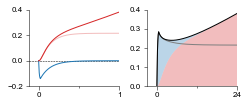

In [14]:
plt.figure(figsize=(3.5,1.5))
ax = plt.subplot(1,2,1)
plt.plot([-3, 24], [0,0], c='k', ls='--', lw=0.5)
plt.plot(t_sol, y_no_input[0,:]-1,lw=1)
plt.plot(t_sol, (y_no_input[1,:]-y_no_input[1,0])/y_no_input[1,0], c='C3',lw=1, alpha=0.3)
plt.plot(t_sol, (y_input[1,:]-y_input[1,0])/y_input[1,0], c='C3',lw=1)

plt.ylim([-0.2, 0.4])
plt.xlim([-3, 24])

ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)
ax.set_xticklabels([0, 1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(1,2,2)

plt.plot(t_sol, gain_no_input/gain_no_input[0]-1, c=(0.5,0.5,0.5),lw=1)
plt.plot(t_sol, gain_input/gain_input[0]-1, c='k',lw=1)
plt.fill_between(t_sol, 0, params['k_eye']*params['mf_sensitivity']*y_input[1,:]/gain_input[0]-1, facecolor='C3',alpha=0.3)
plt.fill_between(t_sol, params['k_eye']*params['mf_sensitivity']*y_input[1,:]/gain_input[0]-1,
                 gain_input/gain_input[0]-1, facecolor='C0',alpha=0.3)

plt.ylim([0, 0.4])
plt.xlim([-3, 24])
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)
ax.set_xticklabels([0, 24])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()